<a href="https://colab.research.google.com/github/Harshithaprudhivi/Team-15-project/blob/main/500hz_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Mount Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# STEP 2: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
# STEP 3: Set Paths
data_path = "/content/drive/MyDrive/PTB-data/npy_records500"
label_path = "/content/drive/MyDrive/PTB-data/ptbxl_database.csv"
scp_path = "/content/drive/MyDrive/PTB-data/scp_statements.csv"
output_path = "/content/drive/MyDrive/PTB_classifier_chunks"
os.makedirs(output_path, exist_ok=True)

In [ ]:
# STEP 4: Load metadata
df = pd.read_csv(label_path)
scp_statements = pd.read_csv(scp_path, index_col=0)


In [ ]:
# STEP 5: Get only diagnostic SCP codes
diagnostic_codes = scp_statements[scp_statements['diagnostic'] == 1].index.tolist()
print("✅ Diagnostic SCP codes used for classification:")
print(diagnostic_codes)



✅ Diagnostic SCP codes used for classification:
['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH', 'LAFB', 'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB', 'ILMI', 'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL', 'LPFB', 'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL', 'WPW', 'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN', 'INJLA', 'PMI', '3AVB', 'INJIL', '2AVB']


In [ ]:

# STEP 6: Filter ECGs that contain at least one diagnostic SCP code
filtered_df = df[df['scp_codes'].map(lambda d: any(k in diagnostic_codes for k in eval(d).keys()))]
print(f"✅ Filtered dataframe shape: {filtered_df.shape}")


✅ Filtered dataframe shape: (21430, 28)


In [ ]:
# STEP 7: Encode labels
all_labels = []
for scp_dict in filtered_df['scp_codes']:
    labels = [k for k in eval(scp_dict).keys() if k in diagnostic_codes]
    all_labels.append(labels)

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(all_labels)
print(f"✅ Y shape: {Y.shape}")

✅ Y shape: (21430, 44)


In [ ]:
# STEP 8: Load matching ECG signal files and store them in chunks
X = []
Y_final = []
chunk_size = 1000  # adjust based on RAM
chunk_idx = 0

ecg_ids = filtered_df['ecg_id'].values
label_index = 0  # to track correct row in Y

In [ ]:
for rid in tqdm(ecg_ids, desc="📥 Processing ECGs"):
    try:
        # Search recursively in subfolders for matching .npy file
        pattern = os.path.join(data_path, "**", f"{int(rid):05d}_hr.npy")
        matches = glob.glob(pattern, recursive=True)

        if not matches:
            print(f"❌ Missing: {rid}_hr.npy")
            continue

        file_path = matches[0]
        x = np.load(file_path)

        # Ensure the shape is correct
        if x.shape != (5000, 12):
            print(f"⚠️ Skipping {rid}: Invalid shape {x.shape}")
            continue

        X.append(x)
        Y_final.append(Y[label_index])

        # Save chunk if full
        if len(X) == chunk_size:
            np.save(os.path.join(output_path, f"X_classifier_500Hz_chunk_{chunk_idx}.npy"), np.array(X))
            np.save(os.path.join(output_path, f"Y_classifier_500Hz_chunk_{chunk_idx}.npy"), np.array(Y_final))
            print(f"💾 Saved chunk {chunk_idx}")
            X, Y_final = [], []
            chunk_idx += 1

    except Exception as e:
        print(f"❌ Error processing {rid}: {e}")

    label_index += 1


📥 Processing ECGs:   5%|▍         | 1000/21430 [10:53<51:35:54,  9.09s/it]

💾 Saved chunk 0


📥 Processing ECGs:   9%|▉         | 2000/21430 [21:22<22:49:02,  4.23s/it]

💾 Saved chunk 1


📥 Processing ECGs:  14%|█▍        | 3000/21430 [32:12<20:29:20,  4.00s/it]

💾 Saved chunk 2


📥 Processing ECGs:  19%|█▊        | 4000/21430 [42:55<14:34:27,  3.01s/it]

💾 Saved chunk 3


📥 Processing ECGs:  23%|██▎       | 5000/21430 [54:18<7:33:32,  1.66s/it]

💾 Saved chunk 4


📥 Processing ECGs:  28%|██▊       | 6000/21430 [1:03:46<12:29:55,  2.92s/it]

💾 Saved chunk 5


📥 Processing ECGs:  33%|███▎      | 7000/21430 [1:13:33<7:15:48,  1.81s/it]

💾 Saved chunk 6


📥 Processing ECGs:  37%|███▋      | 8000/21430 [1:23:43<5:47:42,  1.55s/it]

💾 Saved chunk 7


📥 Processing ECGs:  42%|████▏     | 9000/21430 [1:34:47<9:36:29,  2.78s/it]

💾 Saved chunk 8


📥 Processing ECGs:  47%|████▋     | 10000/21430 [1:45:48<5:46:13,  1.82s/it]

💾 Saved chunk 9


📥 Processing ECGs:  51%|█████▏    | 11000/21430 [1:57:05<7:12:18,  2.49s/it]

💾 Saved chunk 10


📥 Processing ECGs:  56%|█████▌    | 12000/21430 [2:09:34<5:00:41,  1.91s/it]

💾 Saved chunk 11


📥 Processing ECGs:  58%|█████▊    | 12521/21430 [2:14:46<1:04:34,  2.30it/s]

❌ Error processing 12710: No data left in file


📥 Processing ECGs:  61%|██████    | 13001/21430 [2:19:55<6:28:03,  2.76s/it]

💾 Saved chunk 12


📥 Processing ECGs:  65%|██████▌   | 14001/21430 [2:30:48<3:39:54,  1.78s/it]

💾 Saved chunk 13


📥 Processing ECGs:  70%|███████   | 15001/21430 [2:42:39<4:44:34,  2.66s/it]

💾 Saved chunk 14


📥 Processing ECGs:  75%|███████▍  | 16001/21430 [2:54:08<4:33:49,  3.03s/it]

💾 Saved chunk 15


📥 Processing ECGs:  79%|███████▉  | 17001/21430 [3:04:43<2:40:48,  2.18s/it]

💾 Saved chunk 16


📥 Processing ECGs:  84%|████████▍ | 18001/21430 [3:16:05<2:01:49,  2.13s/it]

💾 Saved chunk 17


📥 Processing ECGs:  89%|████████▊ | 19001/21430 [3:28:04<1:23:24,  2.06s/it]

💾 Saved chunk 18


📥 Processing ECGs:  93%|█████████▎| 20001/21430 [3:40:04<1:46:29,  4.47s/it]

💾 Saved chunk 19


📥 Processing ECGs:  98%|█████████▊| 21001/21430 [3:52:03<18:19,  2.56s/it]

💾 Saved chunk 20


📥 Processing ECGs: 100%|██████████| 21430/21430 [3:56:30<00:00,  1.51it/s]


In [ ]:
# Save remaining data if any
if X:
    np.save(os.path.join(output_path, f"X_classifier_500Hz_chunk_{chunk_idx}.npy"), np.array(X))
    np.save(os.path.join(output_path, f"Y_classifier_500Hz_chunk_{chunk_idx}.npy"), np.array(Y_final))
    print(f"💾 Saved final chunk {chunk_idx}")

💾 Saved final chunk 21


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split


In [ ]:
chunk_path = "/content/drive/MyDrive/PTB_classifier_chunks"
model_save_path = "/content/drive/MyDrive/PTB_model/classifier_500Hz.keras"


In [ ]:
# Get all chunk files
x_files = sorted([f for f in os.listdir(chunk_path) if f.startswith("X_classifier")])
y_files = sorted([f for f in os.listdir(chunk_path) if f.startswith("Y_classifier")])


In [ ]:
# Define model
def build_classifier(input_shape, output_dim):
    model = Sequential([
        Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        GlobalAveragePooling1D(),
        Dropout(0.3),
        Dense(output_dim, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# First chunk (to get input/output shape)
X_sample = np.load(os.path.join(chunk_path, x_files[0]))
Y_sample = np.load(os.path.join(chunk_path, y_files[0]))


In [ ]:
model = build_classifier(input_shape=X_sample.shape[1:], output_dim=Y_sample.shape[1])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Training loop
for i in range(len(x_files)):
    print(f"\n📦 Loading chunk {i+1}/{len(x_files)}")

    X = np.load(os.path.join(chunk_path, x_files[i]))
    Y = np.load(os.path.join(chunk_path, y_files[i]))

    # Split into train/val
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

    print(f"📊 Training on chunk {i+1} - Shape: {X_train.shape}, Labels: {Y_train.shape}")

    model.fit(X_train, Y_train,
              validation_data=(X_val, Y_val),
              epochs=10,
              batch_size=32,
              callbacks=[checkpoint, early_stop],
              verbose=1)

print("\n✅ Training complete. Best model saved at:")
print(model_save_path)


📦 Loading chunk 1/22
📊 Training on chunk 1 - Shape: (900, 5000, 12), Labels: (900, 44)
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0489 - loss: 0.5755
Epoch 1: val_loss improved from inf to 0.18380, saving model to /content/drive/MyDrive/PTB_model/classifier_500Hz.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0514 - loss: 0.5712 - val_accuracy: 0.5300 - val_loss: 0.1838
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4982 - loss: 0.1611
Epoch 2: val_loss improved from 0.18380 to 0.11562, saving model to /content/drive/MyDrive/PTB_model/classifier_500Hz.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4980 - loss: 0.1606 - val_accuracy: 0.5300 - val_loss: 0.1156
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4908 - loss: 0.1197
Epoch 3: val_loss improved from 0.11562 to 0.10771, saving model to /content/drive/MyDrive/PTB_model/classifier_500Hz.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4916 - loss:

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import load_model

In [ ]:
# Load trained model
model = load_model("/content/drive/MyDrive/PTB_model/classifier_500Hz.keras")


In [ ]:
import os

file_x = "/content/drive/MyDrive/PTB_classifier_chunks/X_classifier_500Hz_chunk_21.npy"
file_y = "/content/drive/MyDrive/PTB_classifier_chunks/Y_classifier_500Hz_chunk_21.npy"

print("X exists:", os.path.exists(file_x))
print("Y exists:", os.path.exists(file_y))


X exists: True
Y exists: True


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(X_val, batch_size=64)

# Convert probabilities to binary labels (multi-label classification)
y_pred = (y_pred_prob > 0.5).astype(int)


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step   


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Compute micro and macro F1-score
print("F1 Score (micro):", f1_score(Y_val, y_pred, average='micro'))
print("F1 Score (macro):", f1_score(Y_val, y_pred, average='macro'))

# Optional: Show full classification report
print(classification_report(Y_val, y_pred, zero_division=0))


F1 Score (micro): 0.5412844036697247
F1 Score (macro): 0.10861486289207965
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.80      0.33      0.47        12
           7       1.00      0.40      0.57         5
           8       0.50      0.67      0.57         3
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         3
          13       0.43      0.25      0.32        12
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


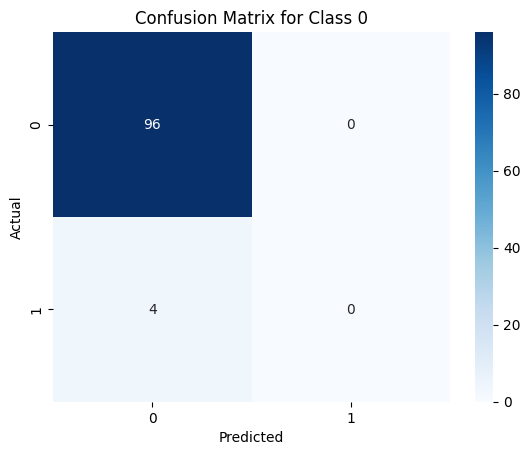

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get confusion matrices for all 20 classes
conf_matrices = multilabel_confusion_matrix(Y_val, y_pred)

# Plot for first label (index 0)
label_index = 0  # change to view other classes

sns.heatmap(conf_matrices[label_index], annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix for Class {label_index}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

# Flatten both arrays (works for multilabel as well)
overall_accuracy = accuracy_score(Y_val.flatten(), y_pred.flatten())
print("🔹 Overall Accuracy: {:.4f}".format(overall_accuracy))


🔹 Overall Accuracy: 0.9773


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming: Y_val = true labels (binary, shape: [n_samples, n_classes])
#           y_pred = predicted labels (binary, shape: [n_samples, n_classes])

# Calculate overall metrics (macro and micro)
precision_micro = precision_score(Y_val, y_pred, average='micro')
recall_micro = recall_score(Y_val, y_pred, average='micro')
f1_micro = f1_score(Y_val, y_pred, average='micro')

precision_macro = precision_score(Y_val, y_pred, average='macro')
recall_macro = recall_score(Y_val, y_pred, average='macro')
f1_macro = f1_score(Y_val, y_pred, average='macro')

# Print results
print(f"Overall Precision (Micro): {precision_micro:.4f}")
print(f"Overall Recall    (Micro): {recall_micro:.4f}")
print(f"Overall F1 Score  (Micro): {f1_micro:.4f}")
print()
print(f"Overall Precision (Macro): {precision_macro:.4f}")
print(f"Overall Recall    (Macro): {recall_macro:.4f}")
print(f"Overall F1 Score  (Macro): {f1_macro:.4f}")


Overall Precision (Micro): 0.7662
Overall Recall    (Micro): 0.4184
Overall F1 Score  (Micro): 0.5413

Overall Precision (Macro): 0.1473
Overall Recall    (Macro): 0.0959
Overall F1 Score  (Macro): 0.1086


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
